# Training CNN

In [1]:
import torch
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np
import os

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.autograd import Variable
from torch import optim

from skimage import io, transform
from random import randint
import shutil

import os, uuid, glob, warnings
import numpy as np

warnings.filterwarnings("ignore")

plt.ion()

In [2]:
transform = transforms.Compose([ 
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])

PARAMETERS FOR FLICKER LOGOS DATASET 27

In [3]:
ORIGINAL_DATA_DIR = '../data/fl27/original'
CROPPED_DATA_DIR = '../data/fl27/images'
ORIGINAL_ANNOTATION = '../data/fl27/annotation.txt'
CROPPED_ANNOTATION = '../data/fl27/crop_annotation.txt'

TRAIN_SET = '../annotations/trainset.txt'
TEST_SET = '../annotations/testset.txt'

PARAMETERS FOR FLICKER LOGOS DATASET 32

In [3]:
ORIGINAL_DATA_DIR = '../data/fl32/originals'
CROPPED_DATA_DIR = '../data/fl32/images'
ORIGINAL_ANNOTATION = '../data/fl32/annotation.txt'
CROPPED_ANNOTATION = '../data/fl32/crop_annotation.txt'


TRAIN_SET = '../annotations/trainset32.txt'
TEST_SET = '../annotations/testset32.txt'

In [4]:
def read_from_annotation(path):
    file = open(path, "r")
    content = file.readlines()
    new = [x.split(" ")[:-1] for x in content]
    return new

In [5]:
def to_var(x, volatile=False):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, volatile=volatile)

In [6]:
class MyDataset(Dataset):
    def __init__(self, txt_file, root,transform=None):
        self.txt_file = txt_file
        self.root = root
        self.transform = transform

    def __len__(self):
        return self.txt_file.shape[0]

    def __getitem__(self, id):
        img_name = os.path.join(self.root, self.txt_file[id][0])
        img = io.imread(img_name)
        if self.transform is not None:
            img = self.transform(img)
        logo = int(self.txt_file[id][1])
        return img,logo

Labels for FL 27

In [7]:
LABELS = ['Adidas', 'Apple', 'BMW', 'Citroen', 'Cocacola', 'DHL', 'Fedex', 'Ferrari', 
          'Ford', 'Google', 'Heineken', 'HP', 'Intel', 'McDonalds', 'Mini', 'Nbc', 'Nike', 'Pepsi', 
          'Porsche', 'Puma', 'RedBull', 'Sprite', 'Starbucks', 'Texaco', 'Unicef', 'Vodafone', 'Yahoo']

In [10]:
LABELS = ['ferrari', 'ups', 'cocacola', 'guiness', 'adidas', 'aldi', 'texaco', 'nvidia', 'rittersport', 
          'paulaner', 'dhl', 'bmw', 'fosters', 'milka', 'starbucks', 'pepsi', 'singha', 'apple', 'fedex',
          'carlsberg', 'hp', 'chimay', 'google', 'tsingtao', 'corona', 'ford', 'esso', 'shell', 'stellaartois', 
          'becks', 'heineken', 'erdinger','nologo']

In [9]:
print(LABELS[20])
print(len(LABELS))

hp
33


In [11]:
def prepare_num_dataset(annotation_path, set_path):
    arr = read_from_annotation(set_path)
    out = []
    for item in arr:
        tmp = [item[0], LABELS.index(item[1].split('\n')[0])]
        out.append(tmp)
    out = np.array(out)
    return out

In [12]:
train_data = prepare_num_dataset(CROPPED_ANNOTATION, TRAIN_SET)
test_data = prepare_num_dataset(CROPPED_ANNOTATION, TEST_SET)
trainset = MyDataset(train_data, CROPPED_DATA_DIR,transform)
testset = MyDataset(test_data, CROPPED_DATA_DIR,transform)
print("Train size {} items and test size {} items".format(len(trainset), len(testset)))

Train size 7404 items and test size 2000 items


In [13]:
batch_size = 5
train_loader = torch.utils.data.DataLoader(dataset=trainset,
                                           batch_size=batch_size,
                                            shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=testset,
                                            batch_size=batch_size,
                                            shuffle=False)

## Training process of CNN

In [17]:
num_epochs = 10
learning_rate = 0.0001
momentum = 0.9

n_classes = len(LABELS)
n_classes

33

In [33]:
class CNN(nn.Module):
    def __init__(self, n_classes):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, n_classes),
        )
    def forward(self, x):
        x = self.features(x)
        print(x)
        print(x.size(0))
        x = x.view(x.size(0), 256 * 6 * 6)
        print(x)
        x = self.classifier(x)
        return x
    
cnn = CNN(n_classes)

In [34]:
cnn.cuda()

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1513363039688/work/torch/lib/THC/generic/THCStorage.cu:58

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr = learning_rate, momentum=momentum)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = to_var(images)
        labels = to_var(labels)
        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f'
            %(epoch+1, num_epochs, i+1, len(trainset)//batch_size, loss.data[0]))

# Save the Trained Model
torch.save(cnn.state_dict(), 'cnn-fl32-vol3.pt')

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1513363039688/work/torch/lib/THC/generic/THCStorage.cu:58

In [16]:
import timeit
start_time = timeit.default_timer()
cnn = CNN(n_classes)
cnn.load_state_dict(torch.load('cnn-fl2-vol3.pt'))
cnn.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images)
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

elapsed = timeit.default_timer() - start_time
print('Test Accuracy of the model on the test images: %d %%' % (100 * correct / total))
print('Time for running: %d' % (elapsed))


Test Accuracy of the model on the test images: 97 %
Time for running: 24


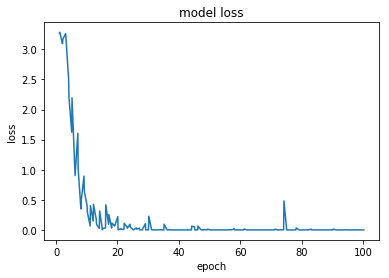

In [16]:
loss_file = 'cnn-vol-2-loss.txt' 
def read_from_loss(file):
    with open (file, "r") as f:
        content = f.readlines()
        content = [x.split(' ') for x in content]
        content = [[x[i].split('\n')[0] for i in range(len(x)) if i%2!=0] for x in content]
        content = [[x[0]+x[1] , x[2]] for x in content]
    data = []
    for item in content:
        tmp = item[0].split(',')
        num = ""
        for t in tmp:
            num += (t.split('/')[0].split('[')[1]) + '.'
        iteration = float(num[:-1])
        data.append([iteration, float(item[1])])
    data = np.array(data)
    plt.plot(data[: , 0], data[: , 1])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
read_from_loss(loss_file)

# Sample testing of the image

In [70]:
import selectivesearch
from skimage.transform import resize
from PIL import Image
from torchvision import transforms 

In [125]:
TEST_IMAGES_FOR_SEGMENTATION = '../data/fl27/segmentation/original'
SEGMENTED_RESIZED_IMAGES = '../data/fl27/segmentation/segmented'

In [126]:
test_images = glob.glob(os.path.join(TEST_IMAGES_FOR_SEGMENTATION,'*.jpg'))

In [127]:
for img in test_images:
    im = io.imread(img)
    img_lbl,regions = selectivesearch.selective_search(im, scale=500, sigma=0.9, min_size=1000)

In [128]:
filtered_regions = []
for item in regions:
    tmp = item['rect']
    if tmp not in filtered_regions:
        filtered_regions.append(tmp)

In [129]:
print(filtered_regions)

[(0, 0, 156, 93), (110, 0, 389, 101), (287, 0, 212, 76), (437, 0, 48, 49), (100, 17, 269, 305), (181, 24, 161, 70), (68, 33, 158, 288), (124, 34, 224, 158), (0, 38, 171, 158), (337, 58, 162, 117), (0, 84, 93, 34), (108, 95, 35, 107), (392, 100, 107, 31), (111, 112, 247, 190), (221, 119, 71, 83), (120, 122, 63, 73), (0, 136, 227, 204), (343, 143, 156, 109), (372, 145, 86, 26), (311, 153, 80, 135), (0, 159, 499, 215), (269, 230, 230, 109), (188, 313, 92, 34), (181, 24, 318, 151), (100, 17, 399, 322), (110, 0, 389, 175), (124, 34, 375, 218), (0, 34, 499, 306), (100, 17, 399, 330), (0, 17, 499, 330), (0, 0, 171, 196), (0, 0, 183, 196), (110, 0, 389, 288), (0, 0, 499, 288), (0, 0, 499, 321), (0, 17, 499, 357), (0, 0, 499, 374)]


In [130]:
for item in filtered_regions:
    rect = item
    x1 = rect[0]
    y1 = rect[1]
    x2 = rect[2]
    y2 = rect[3]
    
    if x1>x2:
        tmp = x1
        x1 = x2
        x2 = tmp
        
    if y1>y2:
        tmp = y1
        y1 = y2
        y2 = tmp
    
    new_img = im[x1:x2, y1:y2]
    resized = resize(new_img,(224,224))
    new_f_name = os.path.join(SEGMENTED_RESIZED_IMAGES,uuid.uuid4().hex+'.jpg')
    
    io.imsave(new_f_name, resized)

In [89]:
def to_var(x, volatile=False):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, volatile=volatile)

def load_image(image, transform=None):
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

In [90]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])

In [75]:
test_cnn = CNN(n_classes)
test_cnn.eval()
test_cnn.load_state_dict(torch.load('cnn-vol-2.pt'))

In [76]:
test_cnn.cuda()

CNN(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (3): Conv2d (64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (6): Conv2d (192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d (384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1))
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_features=4096)
    (5): ReLU(inplace)
    (6): Linear(in

In [145]:
test_image = io.imread(os.path.join(SEGMENTED_RESIZED_IMAGES,'991d371972114c9da5552238e61fa50f.jpg'))
image = load_image(test_image, transform)
image_tensor = to_var(image, volatile=True)

In [146]:
output = test_cnn(image_tensor)
_, predicted = torch.max(output.data, 1)
print(LABELS[int(predicted)])

Unicef
